# Задача

- Найти или сгенерировать набор данных для бинарной классификации графов.
- Реализовать функцию shortest_path_kernel(train_graphs, test_graphs), которая принимает тренировочный и тестовые наборы, а возвращает пару K_train, K_test
    - Опишите графы с помощью вектора из количества кратчайших путей различной длины
    - Для вычисления длин кратчайших путей можно использовать nx.shortest_path_length(G)
    - Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
    - K_train - матрица из ядровых функций для сравнения тренировочных графов между собой
    - K_test - матрица из ядровых функций для сравнения тестовых графов с тренировочными
- Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества
- (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.


### Генерация данных

Сгенерируем два различных класса графов:
- Small-World графы с шумом:

Основаны на модели Ваттса-Строгатца с добавлением случайных ребер
Характеризуются высокой кластеризацией и короткими путями
Применимы для моделирования социальных и биологических сетей
- Смесь моделей с предпочтительным присоединением и блочной структурой:

Комбинация scale-free графов и графов с сообществами
Имеют неравномерное распределение степеней и выраженную групповую структуру
Отражают свойства технологических и социальных сетей с группами


Оба класса содержат шум (15% ребер модифицировано), что размывает различия между ними и делает задачу классификации нетривиальной, но сохраняющей структурные различия.

Генерация графов для классификации...
Генерация завершена: 100 графов класса 1, 100 графов класса 2
Тренировочная выборка: 140 графов, Тестовая выборка: 60 графов


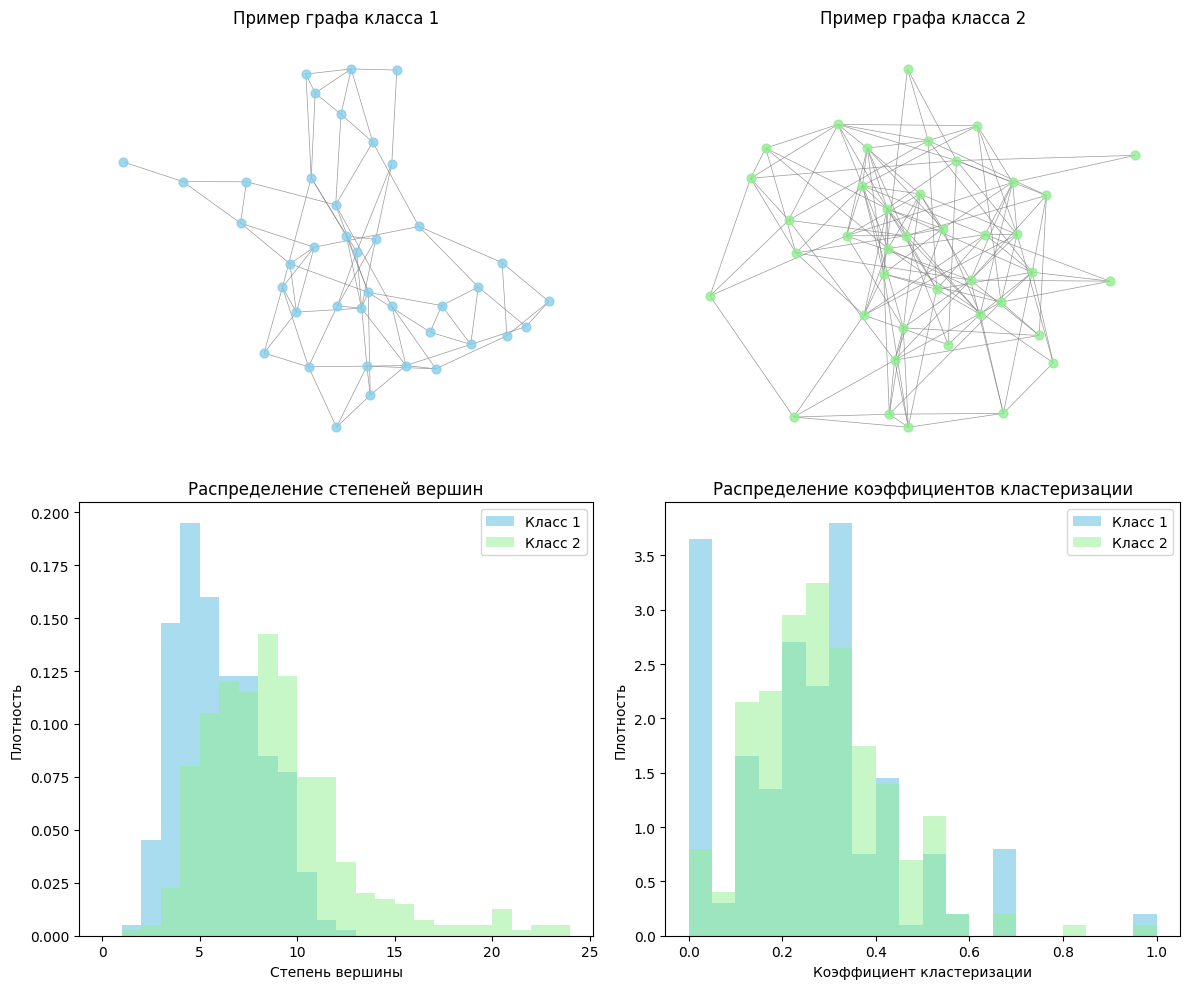

In [12]:
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

n_nodes = 40
n_graphs = 100

def add_noise(G, noise_level=0.1):
    G = G.copy()
    edges = list(G.edges())
    n_noise = int(len(edges) * noise_level)
    
    if n_noise > 0:
        edges_to_remove = random.sample(edges, min(n_noise, len(edges)))
        G.remove_edges_from(edges_to_remove)
    
    nodes = list(G.nodes())
    for _ in range(n_noise):
        u, v = random.sample(nodes, 2)
        if u != v and not G.has_edge(u, v):
            G.add_edge(u, v)
    
    return G

print("Генерация графов для классификации...")

graphs_class1 = []
for _ in range(n_graphs):
    k = random.randint(4, 8)
    p = random.uniform(0.1, 0.3)
    G = nx.watts_strogatz_graph(n_nodes, k, p)
    
    G = add_noise(G, noise_level=0.15)
    
    if nx.is_connected(G):
        graphs_class1.append(G)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()
        
        if len(G) > n_nodes * 0.8:
            missing = n_nodes - len(G)
            if missing > 0:
                G.add_nodes_from(range(len(G), n_nodes))
                existing = list(largest_cc)
                for i in range(len(G), n_nodes):
                    target = random.choice(existing)
                    G.add_edge(i, target)
            graphs_class1.append(G)

graphs_class2 = []
for _ in range(n_graphs):
    if random.random() < 0.5:
        m = random.randint(3, 6)
        G = nx.barabasi_albert_graph(n_nodes, m)
        
        for _ in range(n_nodes * 2):
            nodes = list(G.nodes())
            u = random.choice(nodes)
            neighbors = list(G.neighbors(u))
            if len(neighbors) >= 2:
                v, w = random.sample(neighbors, 2)
                if not G.has_edge(v, w):
                    G.add_edge(v, w)
    else:
        community_sizes = [n_nodes // 3, n_nodes // 3, n_nodes - 2*(n_nodes // 3)]
        p_in = random.uniform(0.3, 0.5)
        p_out = random.uniform(0.05, 0.15)
        
        probs = [[p_in, p_out, p_out], 
                 [p_out, p_in, p_out], 
                 [p_out, p_out, p_in]]
        
        G = nx.stochastic_block_model(community_sizes, probs)
    
    G = add_noise(G, noise_level=0.15)
    
    if nx.is_connected(G):
        graphs_class2.append(G)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()
        if len(G) > n_nodes * 0.8:
            missing = n_nodes - len(G)
            if missing > 0:
                G.add_nodes_from(range(len(G), n_nodes))
                existing = list(largest_cc)
                for i in range(len(G), n_nodes):
                    target = random.choice(existing)
                    G.add_edge(i, target)
            graphs_class2.append(G)

min_len = min(len(graphs_class1), len(graphs_class2))
graphs_class1 = graphs_class1[:min_len]
graphs_class2 = graphs_class2[:min_len]

print(f"Генерация завершена: {len(graphs_class1)} графов класса 1, {len(graphs_class2)} графов класса 2")

labels = np.array([0]*len(graphs_class1) + [1]*len(graphs_class2))
all_graphs = graphs_class1 + graphs_class2

idx = np.arange(len(all_graphs))
train_i, test_i = train_test_split(idx, stratify=labels, test_size=0.3, random_state=SEED)
G_train = [all_graphs[i] for i in train_i]
y_train = labels[train_i]
G_test = [all_graphs[i] for i in test_i]
y_test = labels[test_i]

print(f"Тренировочная выборка: {len(G_train)} графов, Тестовая выборка: {len(G_test)} графов")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

G1 = graphs_class1[0]
pos1 = nx.spring_layout(G1, seed=SEED)
nx.draw(G1, pos1, ax=axes[0, 0], node_size=40, node_color='skyblue', 
        edge_color='gray', alpha=0.8, width=0.5)
axes[0, 0].set_title("Пример графа класса 1")

G2 = graphs_class2[0]
pos2 = nx.spring_layout(G2, seed=SEED)
nx.draw(G2, pos2, ax=axes[0, 1], node_size=40, node_color='lightgreen', 
        edge_color='gray', alpha=0.8, width=0.5)
axes[0, 1].set_title("Пример графа класса 2")

all_degrees1 = []
all_degrees2 = []
for G in graphs_class1[:10]:
    all_degrees1.extend([d for _, d in G.degree()])
for G in graphs_class2[:10]:
    all_degrees2.extend([d for _, d in G.degree()])

axes[1, 0].hist(all_degrees1, bins=range(max(all_degrees1)+2), alpha=0.7, 
                density=True, color='skyblue', label='Класс 1')
axes[1, 0].hist(all_degrees2, bins=range(max(all_degrees2)+2), alpha=0.5, 
                density=True, color='lightgreen', label='Класс 2')
axes[1, 0].set_xlabel('Степень вершины')
axes[1, 0].set_ylabel('Плотность')
axes[1, 0].set_title('Распределение степеней вершин')
axes[1, 0].legend()

all_cc1 = []
all_cc2 = []
for G in graphs_class1[:10]:
    all_cc1.extend(list(nx.clustering(G).values()))
for G in graphs_class2[:10]:
    all_cc2.extend(list(nx.clustering(G).values()))

axes[1, 1].hist(all_cc1, bins=20, alpha=0.7, density=True, 
                color='skyblue', label='Класс 1')
axes[1, 1].hist(all_cc2, bins=20, alpha=0.5, density=True, 
                color='lightgreen', label='Класс 2')
axes[1, 1].set_xlabel('Коэффициент кластеризации')
axes[1, 1].set_ylabel('Плотность')
axes[1, 1].set_title('Распределение коэффициентов кластеризации')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### Shortest-Path Kernel

Ядро кратчайших путей (Shortest-Path Kernel) вычисляет для каждого графа вектор признаков, где каждый элемент соответствует количеству кратчайших путей определенной длины между всеми парами вершин

In [4]:
from itertools import combinations

def shortest_path_kernel(train_graphs, test_graphs, max_path_length=None, n_samples=None):
    graphs_all = train_graphs + test_graphs
    
    if max_path_length is None:
        maxd = 0
        for G in train_graphs:
            path_lengths = dict(nx.all_pairs_shortest_path_length(G))
            for u in path_lengths:
                for v, length in path_lengths[u].items():
                    if length > maxd:
                        maxd = length
    else:
        maxd = max_path_length
        
    def feature_matrix(graphs):
        X = np.zeros((len(graphs), maxd))
        for i, G in enumerate(tqdm(graphs, desc='SP build')):
            dist = dict(nx.all_pairs_shortest_path_length(G))
            
            if n_samples is None:
                for u in G.nodes():
                    for v in G.nodes():
                        if u < v:
                            d = dist[u][v]
                            if d <= maxd and d > 0:
                                X[i, d-1] += 1
            else:
                nodes = list(G.nodes())
                pairs = list(combinations(nodes, 2))
                if len(pairs) > 0:
                    sample_size = min(n_samples, len(pairs))
                    idxs = np.random.choice(len(pairs), size=sample_size, replace=False)
                    for idx in idxs:
                        u, v = pairs[idx]
                        d = dist[u][v]
                        if d <= maxd:
                            X[i, d-1] += 1
        return X
    
    V_train = feature_matrix(train_graphs)
    V_test = feature_matrix(test_graphs)

    K_train = V_train.dot(V_train.T)
    K_test = V_test.dot(V_train.T)
    return K_train, K_test

### Подбор гиперпараметров

Исследуем влияние двух ключевых параметров на производительность ядра кратчайших путей: максимальная длина пути и количество выборочных путей. Для каждого значения параметра вычисляем ядро, обучаем SVM с фиксированным C=1.0 и оцениваем точность на тестовой выборке.

Sampling tuning: 100%|██████████| 5/5 [00:00<00:00,  6.47it/s]


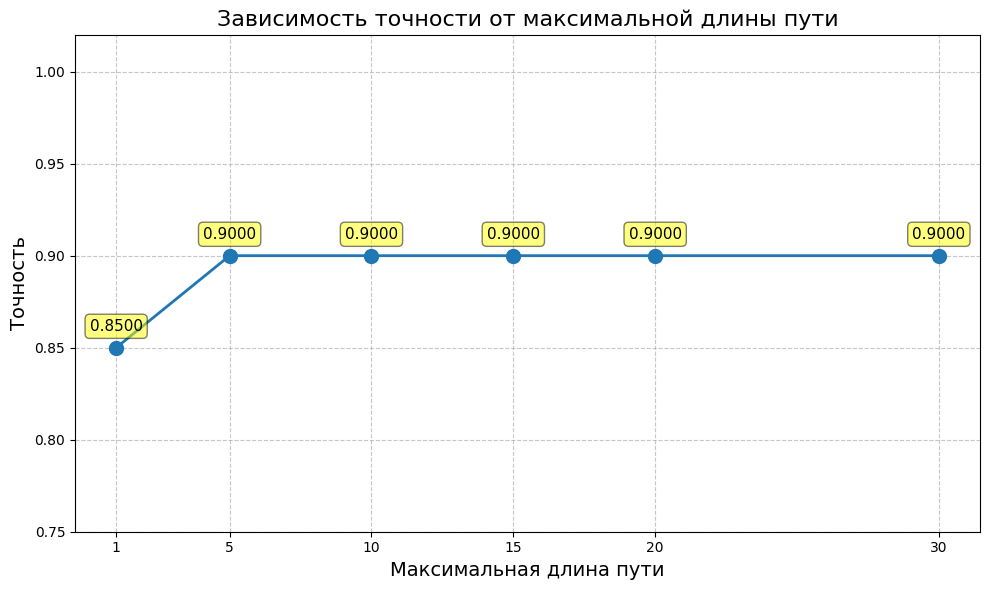

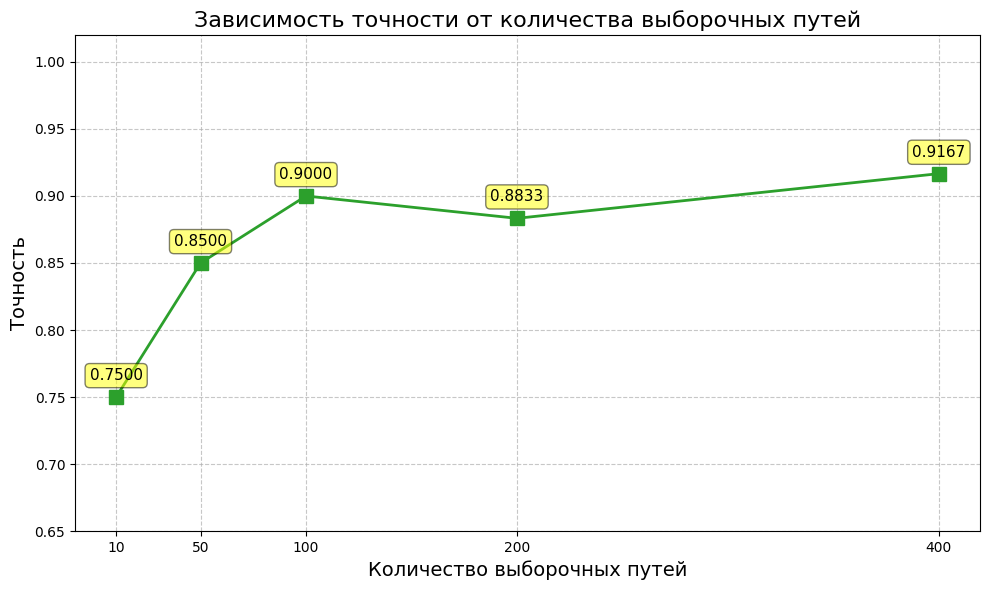

Оптимальная максимальная длина пути: 5
Оптимальное количество выборочных путей: 400
Максимальная точность (max_path): 0.9000
Максимальная точность (n_samples): 0.9167


In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

MAX_PATH_LENGTHS = [1, 5, 10, 15, 20, 30]
SAMPLES_COUNT = [None, 10, 50, 100, 200, 400]
path_accuracy = []
sample_accuracy = []

for max_path in tqdm(MAX_PATH_LENGTHS, desc='Max path tuning'):
    Ktr, Kte = shortest_path_kernel(G_train, G_test, max_path_length=max_path)
    model = SVC(kernel='precomputed', C=1.0, random_state=SEED)
    model.fit(Ktr, y_train)
    y_pred = model.predict(Kte)
    path_accuracy.append(accuracy_score(y_test, y_pred))

for n_s in tqdm([s for s in SAMPLES_COUNT if s is not None], desc='Sampling tuning'):
    Ktr, Kte = shortest_path_kernel(G_train, G_test, n_samples=n_s)
    model = SVC(kernel='precomputed', C=1.0, random_state=SEED)
    model.fit(Ktr, y_train)
    y_pred = model.predict(Kte)
    sample_accuracy.append(accuracy_score(y_test, y_pred))

def scale_y_axis(accuracy_values):
    min_acc = min(accuracy_values)
    y_min = max(0.5, min_acc - 0.1)
    return y_min

plt.figure(figsize=(10, 6))
plt.plot(MAX_PATH_LENGTHS, path_accuracy, 'o-', markersize=10, linewidth=2, color='#1f77b4')

y_min = scale_y_axis(path_accuracy)
plt.ylim(y_min, 1.02)

for i, acc in enumerate(path_accuracy):
    plt.annotate(f'{acc:.4f}', 
                xy=(MAX_PATH_LENGTHS[i], acc),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                va='bottom',
                fontsize=11,
                bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.5))

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Максимальная длина пути', fontsize=14)
plt.ylabel('Точность', fontsize=14)
plt.title('Зависимость точности от максимальной длины пути', fontsize=16)
plt.xticks(MAX_PATH_LENGTHS)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
x_samples = [s for s in SAMPLES_COUNT if s is not None]
plt.plot(x_samples, sample_accuracy, 's-', markersize=10, linewidth=2, color='#2ca02c')

y_min = scale_y_axis(sample_accuracy)
plt.ylim(y_min, 1.02)

for i, acc in enumerate(sample_accuracy):
    plt.annotate(f'{acc:.4f}', 
                xy=(x_samples[i], acc),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                va='bottom',
                fontsize=11,
                bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.5))

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Количество выборочных путей', fontsize=14)
plt.ylabel('Точность', fontsize=14)
plt.title('Зависимость точности от количества выборочных путей', fontsize=16)
plt.xticks(x_samples)
plt.tight_layout()
plt.show()

best_max_path = MAX_PATH_LENGTHS[np.argmax(path_accuracy)]
best_sample_count = [s for s in SAMPLES_COUNT if s is not None][np.argmax(sample_accuracy)]

print(f"Оптимальная максимальная длина пути: {best_max_path}")
print(f"Оптимальное количество выборочных путей: {best_sample_count}")
print(f"Максимальная точность (max_path): {max(path_accuracy):.4f}")
print(f"Максимальная точность (n_samples): {max(sample_accuracy):.4f}")

### Weisfeiler–Lehman Subtree Kernel

Ядро Вейсфейлера-Лемана (Weisfeiler-Lehman Subtree Kernel) вычисляет для каждого графа вектор признаков, где каждый элемент соответствует количеству вершин с определенной структурой соседства. Алгоритм итеративно переименовывает метки вершин, учитывая метки соседей, что позволяет улавливать структурные паттерны в графе на разных масштабах. На каждой итерации новые метки вершин формируются путем объединения их текущих меток с упорядоченным набором меток всех соседей, что эффективно кодирует подграфы увеличивающегося размера.

In [6]:
from collections import Counter
from hashlib import sha1

def wl_features(graphs, h=3):
    labels = [{v: '0' for v in G.nodes()} for G in graphs]
    
    feats = [Counter(l.values()) for l in labels]
    
    for _ in range(h):
        new_labels = []
        for i, G in enumerate(graphs):
            nl = {}
            for v in G.nodes():
                neigh = sorted(labels[i][u] for u in G.neighbors(v))
                tpl = (labels[i][v], *neigh)
                nl[v] = sha1(str(tpl).encode()).hexdigest()
            new_labels.append(nl)
            feats[i].update(nl.values())
        labels = new_labels
    
    all_labels = sorted({lab for cnt in feats for lab in cnt})
    idx = {lab: j for j, lab in enumerate(all_labels)}
    X = np.zeros((len(graphs), len(all_labels)))
    for i, cnt in enumerate(feats):
        for lab, c in cnt.items():
            X[i, idx[lab]] = c
    
    return X

### Обучение SVM и сравнение результатов

G_train: 140, y_train: 140


SP build: 100%|██████████| 60/60 [00:00<00:00, 1852.31it/s]

K_sp_train shape: (140, 140)
y_train shape: 140


SP best C= 0.01
              precision    recall  f1-score   support

           0      0.929     0.867     0.897        30
           1      0.875     0.933     0.903        30

    accuracy                          0.900        60
   macro avg      0.902     0.900     0.900        60
weighted avg      0.902     0.900     0.900        60

Вычисление WL-ядра...
K_wl_train shape: (140, 140)
WL best C= 0.1
              precision    recall  f1-score   support

           0      0.900     0.900     0.900        30
           1      0.900     0.900     0.900        30

    accuracy                          0.900        60
   macro avg      0.900     0.900     0.900        60
weighted avg      0.900     0.900     0.900        60



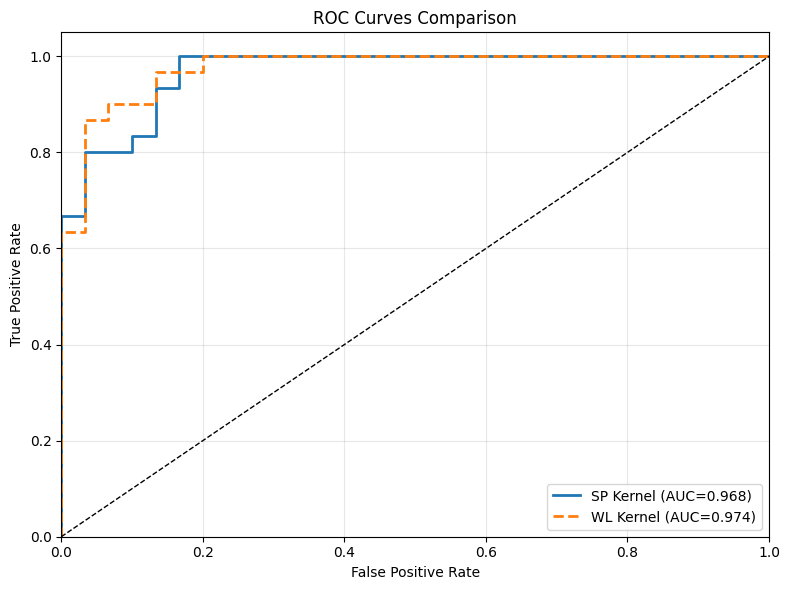

In [ ]:
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations
from collections import Counter
from hashlib import sha1

def compute_kernel(X1, X2=None):
    if X2 is None: X2 = X1
    return np.dot(X1, np.transpose(X2))

def shortest_path_kernel(train_graphs, test_graphs, max_path_length=None, n_samples=None):
    graphs_all = train_graphs + test_graphs
    
    if max_path_length is None:
        maxd = 0
        for G in train_graphs:
            path_lengths = dict(nx.all_pairs_shortest_path_length(G))
            for u in path_lengths:
                for v, length in path_lengths[u].items():
                    maxd = max(maxd, length)
    else:
        maxd = max_path_length
        
    def feature_matrix(graphs):
        X = np.zeros((len(graphs), maxd))
        for i, G in enumerate(tqdm(graphs, desc='SP build')):
            dist = dict(nx.all_pairs_shortest_path_length(G))
            
            if n_samples is None:
                for u in G.nodes():
                    for v in G.nodes():
                        if u < v:
                            d = dist[u][v]
                            if d <= maxd and d > 0:
                                X[i, d-1] += 1
            else:
                nodes = list(G.nodes())
                pairs = list(combinations(nodes, 2))
                if len(pairs) > 0:
                    sample_size = min(n_samples, len(pairs))
                    idxs = np.random.choice(len(pairs), size=sample_size, replace=False)
                    for idx in idxs:
                        u, v = pairs[idx]
                        d = dist[u][v]
                        if d <= maxd and d > 0:
                            X[i, d-1] += 1
        return X
    
    V_train = feature_matrix(train_graphs)
    V_test = feature_matrix(test_graphs)

    K_train = V_train.dot(V_train.T)
    K_test = V_test.dot(V_train.T)
    return K_train, K_test

def wl_features(graphs, h=3):
    labels = [{v: '0' for v in G.nodes()} for G in graphs]
    
    feats = [Counter(l.values()) for l in labels]
    
    for _ in range(h):
        new_labels = []
        for i, G in enumerate(graphs):
            nl = {}
            for v in G.nodes():
                neigh = sorted(labels[i][u] for u in G.neighbors(v))
                tpl = (labels[i][v], *neigh)
                nl[v] = sha1(str(tpl).encode()).hexdigest()
            new_labels.append(nl)
            feats[i].update(nl.values())
        labels = new_labels
    
    all_labels = sorted({lab for cnt in feats for lab in cnt})
    idx = {lab: j for j, lab in enumerate(all_labels)}
    X = np.zeros((len(graphs), len(all_labels)))
    for i, cnt in enumerate(feats):
        for lab, c in cnt.items():
            X[i, idx[lab]] = c
    
    return X

print(f"G_train: {len(G_train)}, y_train: {len(y_train)}")

K_sp_train, K_sp_test = shortest_path_kernel(G_train, G_test)

print(f"K_sp_train shape: {K_sp_train.shape}")
print(f"y_train shape: {len(y_train)}")

def train_precomputed(K_train, y_train, cv_splits=5):
    assert K_train.shape[0] == len(y_train), f"Размеры не совпадают: K_train {K_train.shape[0]}, y_train {len(y_train)}"
    
    svc = SVC(kernel='precomputed', probability=True)
    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=SEED)
    grid = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy')
    grid.fit(K_train, y_train)
    return grid.best_estimator_, grid.best_params_

clf_sp, params_sp = train_precomputed(K_sp_train, y_train)
y_pred_sp = clf_sp.predict(K_sp_test)
y_score_sp = clf_sp.decision_function(K_sp_test)
print("SP best C=", params_sp['C'])
print(classification_report(y_test, y_pred_sp, digits=3))

print("Вычисление WL-ядра...")
X_wl_all = wl_features(G_train + G_test, h=3)
X_wl_train = X_wl_all[:len(G_train)]
X_wl_test = X_wl_all[len(G_train):]

K_wl_train = compute_kernel(X_wl_train)
K_wl_test = compute_kernel(X_wl_test, X_wl_train)

print(f"K_wl_train shape: {K_wl_train.shape}")

clf_wl, params_wl = train_precomputed(K_wl_train, y_train)
print("WL best C=", params_wl['C'])

y_pred_wl = clf_wl.predict(K_wl_test)
y_score_wl = clf_wl.decision_function(K_wl_test)
print(classification_report(y_test, y_pred_wl, digits=3))

plt.figure(figsize=(8, 6))
fpr_sp, tpr_sp, _ = roc_curve(y_test, y_score_sp)
fpr_wl, tpr_wl, _ = roc_curve(y_test, y_score_wl)

plt.plot(fpr_sp, tpr_sp, lw=2, label=f'SP Kernel (AUC={auc(fpr_sp,tpr_sp):.3f})')
plt.plot(fpr_wl, tpr_wl, '--', lw=2, label=f'WL Kernel (AUC={auc(fpr_wl,tpr_wl):.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Анализ результатов
Хотя оба ядра показали одинаковую итоговую точность, Weisfeiler-Lehman демонстрирует более стабильные и сбалансированные результаты по всем метрикам и классам. Это может быть обусловлено тем, что WL-ядро лучше улавливает структурные особенности графов через итеративный процесс обновления меток вершин, учитывая локальную окрестность каждой вершины на разных уровнях.
Однако разница между методами не является значительной, что говорит о том, что для данной задачи оба подхода имеют достаточную различающую способность.